# "Part 1: GeoFLOW - How to create effective GeoSpatial workflow using Python & Jupyter Notebook"
> "GeoSpatial Data Analysis has a visual component to it. As a Data Scientist, you would prefer to look at the intermediary steps in the processing pipeline. This has a two fold impact, first, it provides a better intutition about your data & second, makes bug trackking easier. Let us try to understand this better, by solving a mystery, Where do people tend to live?"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [GIS]
- image: images/geoflow-banner-1.png

<a href="google.com" role="button" target="_blank"><img class="notebook-badge-image" src="{{ "assets/badges/github.svg" | relative_url }}" alt="View On GitHub"></a>

# Where do people live?

Population data is available at a low spatial & temporal resolution. For most of the countries around the world, it is done once every 10 years & available at a ward level at best.

Goverment, NGOs & other public bodies design a lot of policy & measures based on this outdated data. In the event of an endemic or natural disaster, it would help a lot if you know exactly where people live & track their movements.

To address this issue, we will try to estimate the human population at 100m x 100m GRID level. Using Building footprints as proxy for human settlement, we will see how to distribute a global datasource like Gridded Population of the World (GPW) can be used to estimate the human population at such granular resolution.

# Details of the city under consideration

We are looking at the city of [Fortportal, which is regarded as the tourism city in Uganda](https://en.wikipedia.org/wiki/Fort_Portal)

In [1]:
REGION = 'fortportal'
UTM = 32636
PIPELINE = 'output'

In [2]:
# Parameters
REGION = "fortportal"
UTM = 32636
PIPELINE = "gridded-population"


In [3]:
#hide
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import seaborn as sns
import warnings

from datetime import datetime as dt
from pathlib import Path
from rasterio.mask import mask
from shapely.geometry import Polygon

WGS84 = 4326
MERCATOR = 3857
CWD = Path('.')
DATA = Path('data')

INTER  = DATA/'inter'
INPUT  = DATA/'input'
OUTPUT = DATA/'output'

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
# hide
def show(*args):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.set_axis_off()
    
    for d in args:
        if type(d) is gpd.GeoDataFrame:
            d.plot(ax=ax, facecolor='olive', edgecolor='white', alpha=0.5)
        elif type(d) is np.ndarray:
            ax.imshow(d, cmap='RdYlGn_r', extent=box[[0,2,1,3]])
        else:
            continue

# Load the city boundary GeoJSON file

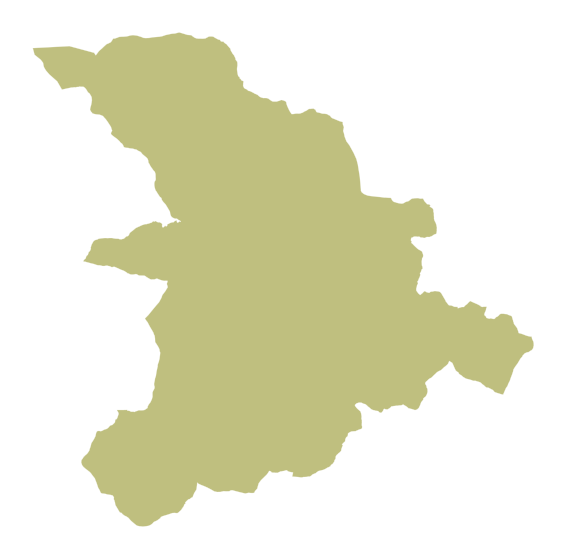

In [5]:

# Read the data & change the CRS to 4326
region = gpd.read_file(INPUT/f'{REGION}.geojson').to_crs(epsg=WGS84)
box    = region.total_bounds

show(region)

# Load Population data

- Read the [Gridded Population of the World (GPW)](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4) dataset, which is available as a Raster TIFF file
- Clip it to the city boundary using the GeoJSON file
- Save the clipped raster

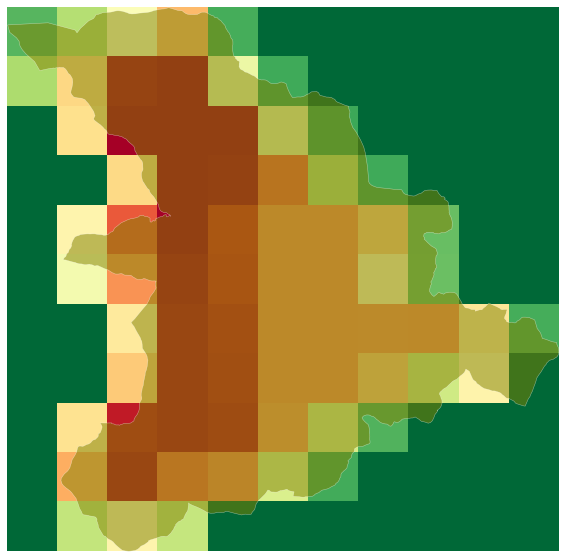

In [6]:

# Read GPW data
gpw = rio.open(INPUT/'gpw_world.tif')
gpw_region = gpw.read(1, window=gpw.window(*box))

# Clip to the region boundary
region_mask, region_mask_tfm = mask(dataset=gpw, shapes=region.geometry, all_touched=True, crop=True, filled=True)
region_mask = np.where(region_mask < 0, 0, region_mask).squeeze()

# Save the clipped raster
region_meta = gpw.meta
region_meta.update(dict(
    driver='GTiff',
    height=region_mask.shape[0],
    width=region_mask.shape[1],
    transform=region_mask_tfm
))
with rio.open(INTER/f'{REGION}_gpw_output.tif', 'w', **region_meta) as f: f.write(region_mask, indexes=1)

show(region, region_mask)

# Polygonize the clipped raster

Population data for the city is now available as a Raster TIFF file. In order to read it as a GeoDataFrame & perform spatial operations, we would need to polygonise the raster into a vector format.

We can do this using the rasterio library in python.

> Tip: Use rasterio CLI inside jupyter notebooks, save a few lines of pythonic code

In [7]:

# Converts vector to raster
!rio shapes {INTER/REGION}_gpw_output.tif --bidx 1 --precision 6 > {INTER/REGION}_gpw_output.geojson

In [8]:
#hide_input
# Clean vectorized GPW data & add tile_width, tile_height as properties

from functools import wraps
from datetime import datetime as dt


def log(fn):
    @wraps(fn)
    def _inner(*args, **kwargs):
        tic = dt.now()
        r = fn(*args, **kwargs)
        tac = dt.now()
        # print(f'Shape: {r.shape}, Execution time: {((tac - tic).microseconds)/1000:.2f} ms, Function: {fn.__name__}')
        return r
    return _inner

@log
def make_copy(df): return df.copy()

@log
def drop_cols(df, labels=None): return df.drop(labels, axis=1)

@log
def filter_rows(df, cond): return df.query(cond)

@log
def change_crs(df, crs): return df.to_crs(epsg=crs)

@log
def add_attrs(df):
    bounds = df.geometry.bounds
    width  = bounds['maxx'] - bounds['minx']
    height = bounds['maxy'] - bounds['miny']
    
    min_width  = np.min(width)
    min_height = np.min(height)
    
    df['width']  = ((bounds['maxx'] - bounds['minx']) / min_width ).astype(int)
    df['height'] = ((bounds['maxy'] - bounds['miny']) / min_height).astype(int)
    
    df = df.reset_index(drop=True).reset_index()
    df = df.rename(columns={'index': 'tile_idx', 'val': 'tile_population', 'width': 'tile_width', 'height': 'tile_height'})
    
    return df

tiles_gdf = gpd.read_file(f'{INTER/REGION}_gpw_output.geojson')

tiles_gdf = (tiles_gdf.pipe(make_copy)
            .pipe(drop_cols, labels=['id', 'filename'])
            .pipe(filter_rows, 'val > 0')
            .pipe(change_crs, MERCATOR)
            .pipe(add_attrs))

display(tiles_gdf.head())

# BUG in rasterio: Combines adjacent tiles but doesn't aggregate the values
tiles_gdf['tile_population'] = tiles_gdf['tile_population'] * (tiles_gdf.tile_width * tiles_gdf.tile_height)

# The area printed is not correct, as the projection is MERCATOR
print(f'# of tiles: {tiles_gdf.shape[0]}, Area covered: {tiles_gdf.area.sum() / 1000000:.2f} km.sq')

print(f'''Population statistics: mean: {tiles_gdf.tile_population.mean():.2f}, median: {tiles_gdf.tile_population.median():.2f}, std: {tiles_gdf.tile_population.std():.2f}''')

,tile_idx,tile_population,geometry,tile_width,tile_height
0,0,288.332520,"POLYGON ((3366486.971 77925.582, 3366486.971 7...",1,1
1,1,521.265198,"POLYGON ((3367414.596 77925.582, 3367414.596 7...",1,1
2,2,780.061462,"POLYGON ((3368342.222 77925.582, 3368342.222 7...",1,1
3,3,1066.110474,"POLYGON ((3369269.958 77925.582, 3369269.958 7...",1,1
4,4,253.477982,"POLYGON ((3370197.584 77925.582, 3370197.584 7...",1,1


# of tiles: 68, Area covered: 61.96 km.sq
Population statistics: mean: 1068.56, median: 1025.65, std: 547.29


# Gridify

The vectorized GPW GeoJSON file gives us **population** for the city at **1km x 1km spatial resolution**.

The intent is to estimate the population at **100m x 100m spatial resolution**. To achieve this, we have to:
- Gridify: Split the 1km x 1km TILE into smaller grids of size 100m x 100m
- Each 1km x 1km TILE will give us 100 GRIDs of size 100m x 100m

> Tip: Gridification works well only for the MERCATOR projection, make sure your GeoDataFrames have proper CRS before performing this operation.

In [9]:
def gridify(tile):
    polygons = []
    xmin,ymin,xmax,ymax = tile.geometry.bounds
    width = tile.tile_width
    height = tile.tile_height

    stepx = +(xmax - xmin)/(10 * width )
    stepy = -(ymax - ymin)/(10 * height)

    for x in np.arange(xmin, xmax, stepx):
        for y in np.arange(ymax, ymin, stepy):
            poly = [
                (x        , y        ),
                (x + stepx, y        ),
                (x + stepx, y + stepy),
                (x        , y + stepy)
            ]
            polygons.append(Polygon(poly))

    d = {
        'geometry': polygons,
        'tile_idx': tile.tile_idx,
        'tile_population': tile.tile_population,
        'tile_width': tile.tile_width,
        'tile_height': tile.tile_height
    }
    
    grids_gdf = gpd.GeoDataFrame(d, crs=f'EPSG:{MERCATOR}')
    tile_gdf  = gpd.GeoDataFrame(tile.to_frame().T, crs=f'EPSG:{MERCATOR}')
    grids_gdf = gpd.clip(grids_gdf, tile_gdf)
        
    return grids_gdf

# For each TILE create the GRIDs
grids_gdf = tiles_gdf.apply(gridify, axis=1)
grids_gdf = pd.concat(grids_gdf.to_list())
grids_gdf = grids_gdf.reset_index(drop=True).reset_index().rename(columns={'index': 'idx'}).to_crs(epsg=UTM)

# Change the CRS of TILEs & GRIDs back to their region respective UTM coordinates
tiles_gdf = tiles_gdf.to_crs(epsg=UTM)
grids_gdf = grids_gdf.to_crs(epsg=UTM)
region = region.to_crs(epsg=UTM)

grids_gdf.head()

,idx,geometry,tile_idx,tile_population,tile_width,tile_height
0,0,"POLYGON ((192969.965 77461.414, 193062.792 774...",0,288.33252,1,1
1,1,"POLYGON ((192969.911 77369.202, 193062.738 773...",0,288.33252,1,1
2,2,"POLYGON ((192969.857 77276.990, 193062.684 772...",0,288.33252,1,1
3,3,"POLYGON ((192969.803 77184.777, 193062.630 771...",0,288.33252,1,1
4,4,"POLYGON ((192969.749 77092.565, 193062.576 770...",0,288.33252,1,1


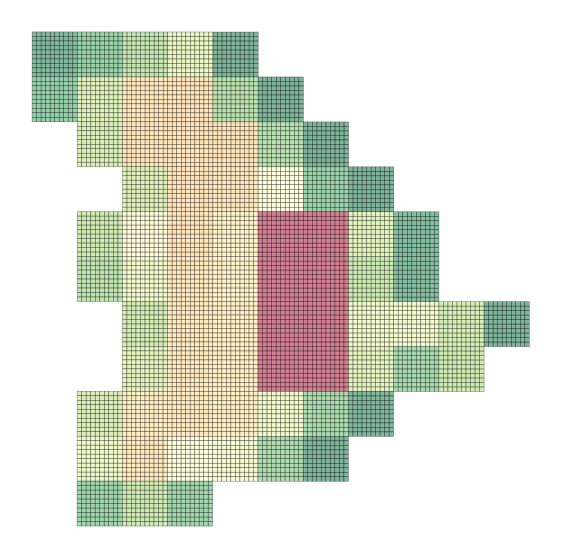

In [10]:
#hide_input
# Plot the 100m x 100m GRIDs for each TILE
fig, ax = plt.subplots(1,1,figsize=(10, 10))
grids_gdf.plot(ax=ax, cmap='RdYlGn_r', edgecolor='k', alpha=0.5, column='tile_population')
ax.set_axis_off()

# Load building footprints dataset

We are using buildings as a proxy for estimating the human population.

Microsoft has been kind of to release building footprints for multiple regions around the globe, please check them out [HERE](https://www.microsoft.com/en-us/maps/building-footprints). Fortunately, the city we are considering here (Fortportal in Uganda) is also made available by them.

If you are considering a region for which there are no readily available building footprints, here are a few alternatives:
- Check Open Street Map (OSM), they have a good coverage of a lot of places around the globe. Also, consider contributing to that as well
- Put your deep learning skills in practice, try getting hands on some satellite imagery of the region & generate building footprints using Segmentation models. Dave luo has a nice blog post about the same [LINK](https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321).

In [11]:

# Read the building footprints data, compute the centroid & area occupied by each building
footprints_gdf = (gpd.read_file(f'{INPUT/REGION}_footprints.geojson')
                     .to_crs(epsg=UTM)
                     .assign(centroid=lambda x: x.centroid,
                             building_area=lambda x:x.geometry.area)
                     .rename(columns={'geometry': 'building_count'})
                     .set_geometry('centroid'))

footprints_gdf.head()

,building_count,centroid,building_area
0,"MULTIPOLYGON (((194684.966 75640.197, 194680.2...",POINT (194676.911 75641.532),128.630075
1,"MULTIPOLYGON (((195342.053 76164.558, 195341.3...",POINT (195339.047 76167.382),33.503853
2,"MULTIPOLYGON (((196345.656 75470.388, 196343.7...",POINT (196347.957 75471.430),112.972240
3,"MULTIPOLYGON (((196429.562 75712.346, 196424.1...",POINT (196424.420 75711.871),52.979150
4,"MULTIPOLYGON (((196340.025 76339.930, 196346.4...",POINT (196341.162 76345.245),59.647773


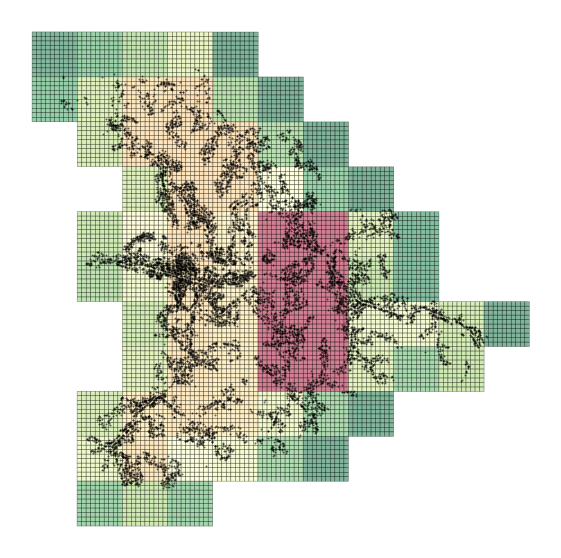

In [12]:
#hide_input
fig, ax = plt.subplots(1,1,figsize=(10, 10))
grids_gdf.plot(ax=ax, cmap='RdYlGn_r', edgecolor='black', alpha=0.5, column='tile_population')
footprints_gdf.plot(ax=ax, color='black', alpha=0.5, markersize=2)
ax.set_axis_off()

# Compute building statistics (# of buildings, area occupied by buildings) for each GRID

Now, we have:
- GRIDs at 100m x 100m resolution
- Building footprints for the city

We would like to find the buildings falling under each GRID & then compute their count & area occupancy. We can do a spatial join between the two DataFrames, which is much faster thanks to geopandas > 0.8. We take the centroid of each building footprints & do a spatial join with the GRID boundaries.

In [13]:
def sjoin_polygon_footprints(poly_gdf, footprints_gdf, idx, name, agg):
    poly_gdf = gpd.sjoin(poly_gdf, footprints_gdf, how='left', op='intersects')
    poly_gdf = (poly_gdf.groupby(idx)
                        .agg(agg)
                        .reset_index())
    
    poly_gdf = (gpd.GeoDataFrame(poly_gdf, crs=f'EPSG:{UTM}')
              .rename(columns={'building_area' : f'{name}_building_area', 
                               'building_count': f'{name}_building_count'}))
    
    return poly_gdf

agg = {
    'geometry'           : 'first',
    'building_area'      : 'sum',
    'building_count'     : 'count',
    'tile_idx'           : 'first',
    'tile_population'    : 'first',
    'tile_width'         : 'first',
    'tile_height'        : 'first'
}

grids_gdf = sjoin_polygon_footprints(grids_gdf, footprints_gdf, 'idx', 'grid', agg=agg)
grids_gdf.head()

,idx,geometry,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height
0,0,"POLYGON ((192969.965 77461.414, 193062.792 774...",0.0,0,0,288.33252,1,1
1,1,"POLYGON ((192969.911 77369.202, 193062.738 773...",0.0,0,0,288.33252,1,1
2,2,"POLYGON ((192969.857 77276.990, 193062.684 772...",0.0,0,0,288.33252,1,1
3,3,"POLYGON ((192969.803 77184.777, 193062.630 771...",0.0,0,0,288.33252,1,1
4,4,"POLYGON ((192969.749 77092.565, 193062.576 770...",0.0,0,0,288.33252,1,1


# Remove extra GRIDs that fall beyond the region boundary & adjust the population accordingly

The GPW population data is available to us at 1km x 1km resolution, we are clipping that to the region boundary. When we split the TILE into GRIDs, along the edges there will be GRIDs that fall beyond the region boundary. However, we will not have building footprints available for areas outside our region boundary, so we remove the extra grids & adjust the population count by taking a ratio of the # of grids that fall with in the region boundary. 

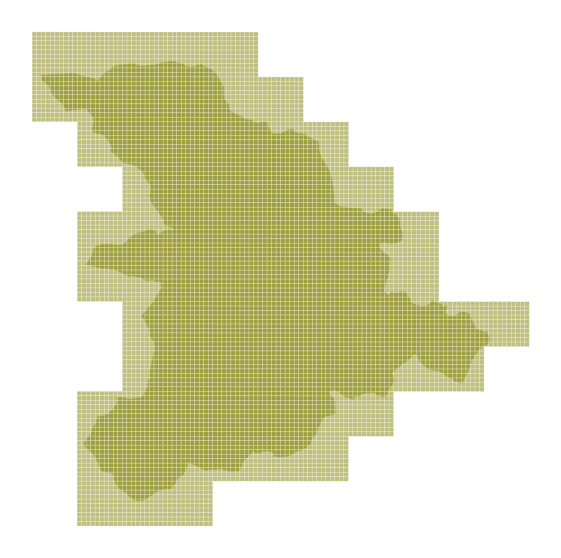

In [14]:
#hide_input
show(region, grids_gdf)

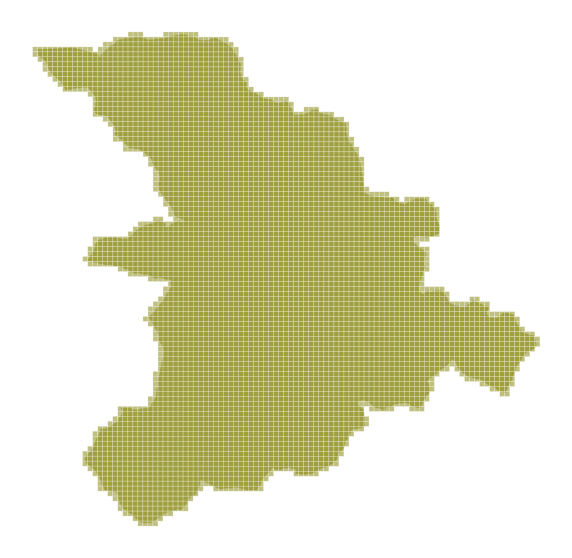

In [15]:
#collapse-hide
grids_gdf = gpd.sjoin(grids_gdf, region[['geometry']], how='inner', op='intersects').drop(labels='index_right', axis=1)

# Fix the index of the grids
grids_gdf = (grids_gdf.drop(labels='idx', axis=1)
                      .reset_index(drop=True).reset_index()
                      .rename(columns={'index': 'idx'}))

# Adjust the population accordingly

def recompute_population_by_grids(gp):
    if gp.grid_building_count.sum() <= 1:  gp.tile_population = 0
    return gp.tile_population * (gp.shape[0] / (gp.tile_width * gp.tile_height * 100))

grids_gdf['tile_population'] = (grids_gdf.groupby('tile_idx')
                                         .apply(recompute_population_by_grids)
                                         .values)

show(region, grids_gdf)

In [16]:
#hide_input
grids_gdf.head()

,idx,geometry,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height
0,0,"POLYGON ((193062.306 76631.449, 193155.133 766...",0.0,0,0,25.949927,1,1
1,1,"POLYGON ((193155.133 76631.395, 193247.960 766...",0.0,0,0,25.949927,1,1
2,2,"POLYGON ((193247.960 76631.341, 193340.787 766...",0.0,0,0,25.949927,1,1
3,3,"POLYGON ((193340.787 76631.287, 193433.613 766...",0.0,0,0,25.949927,1,1
4,4,"POLYGON ((193433.613 76631.233, 193526.440 766...",0.0,0,0,25.949927,1,1


# Compute the Population at 100m x 100m GRID level

For each grid, we have the TILE population, # of buildings inside it's boundary & the area of building inside it's boundary.

We can statistically distribute the TILE population to the GRIDs by considering the building properties inside them. Like we discussed, buildings are a good proxy for human population.

```
# Tile population distributed by the ratio of # of buildings for each grid
grid_population_count = tile_population * (grid_building_count / tile_building_count)

# Tile population distributed by the ratio of area of buildings for each grid
grid_population_area  = tile_population * (grid_building_area  / tile_building_area )

grid_population = Weighted average of the above 2 metrics
```

> Tip: If you would like to improve over this model, conside using DEM & DSM dataset, to find building heights & use it as a factor to distribute the population

In [17]:

# Aggregate to get TILE stats
grids_gdf[['tile_building_count', 'tile_building_area']] = grids_gdf.groupby('tile_idx')[['grid_building_count', 'grid_building_area']].transform('sum')

# Statistically distribute the TILE population to GRIDs
grids_gdf['grid_population'] = (0.5 * grids_gdf['tile_population'] * (grids_gdf['grid_building_count'] / grids_gdf['tile_building_count']) + 
                                0.5 * grids_gdf['tile_population'] * (grids_gdf['grid_building_area' ] / grids_gdf['tile_building_area' ]))

grids_gdf.loc[:, 'grid_population'] = grids_gdf['grid_population'].fillna(0)

grids_gdf.head()

,idx,geometry,grid_building_area,grid_building_count,tile_idx,tile_population,tile_width,tile_height,tile_building_count,tile_building_area,grid_population
0,0,"POLYGON ((193062.306 76631.449, 193155.133 766...",0.0,0,0,25.949927,1,1,2,346.301592,0.0
1,1,"POLYGON ((193155.133 76631.395, 193247.960 766...",0.0,0,0,25.949927,1,1,2,346.301592,0.0
2,2,"POLYGON ((193247.960 76631.341, 193340.787 766...",0.0,0,0,25.949927,1,1,2,346.301592,0.0
3,3,"POLYGON ((193340.787 76631.287, 193433.613 766...",0.0,0,0,25.949927,1,1,2,346.301592,0.0
4,4,"POLYGON ((193433.613 76631.233, 193526.440 766...",0.0,0,0,25.949927,1,1,2,346.301592,0.0


# Let us look how the population distribution varies at 1km & 100m resolution

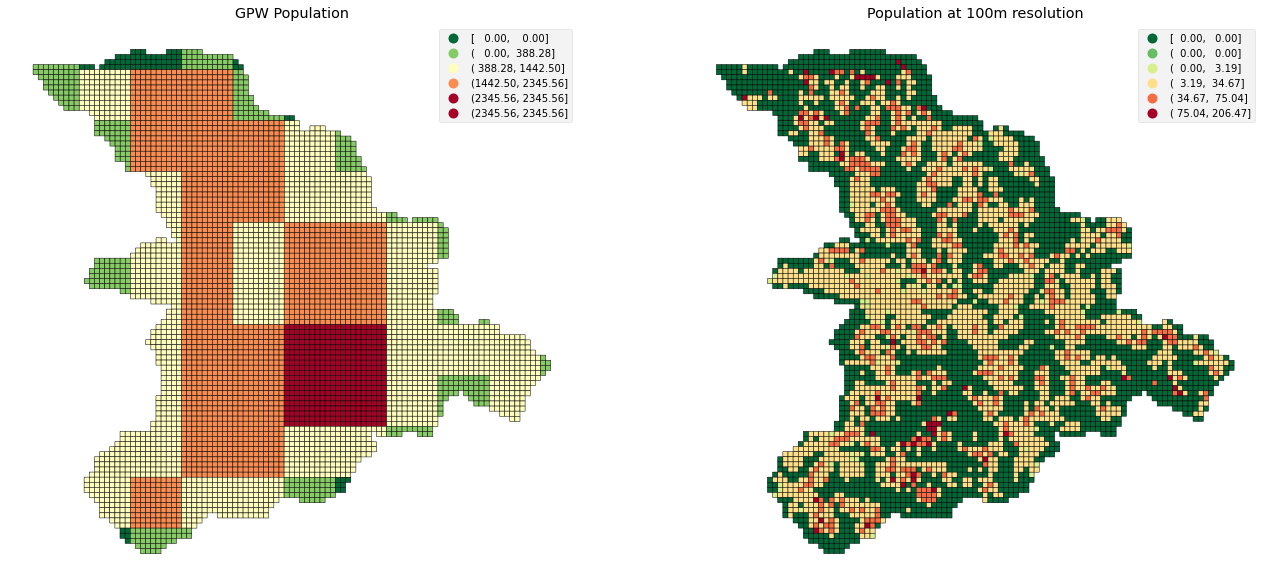

In [18]:
#hide_input
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 20))
grids_gdf.plot(ax=ax1, cmap='RdYlGn_r', edgecolor='black', alpha=1, column='tile_population', scheme='percentiles', legend=True)
grids_gdf.plot(ax=ax2, cmap='RdYlGn_r', edgecolor='black', alpha=1, column='grid_population', scheme='percentiles', legend=True)

ax1.set_title('GPW Population')
ax2.set_title('Population at 100m resolution')
ax1.set_axis_off()
ax2.set_axis_off()

# Save the 100m x 100m GRID DataFrame

> Tip: If you need the data for futher processing, consider using the feather format available in geopandas, it speeds up the reading & writing of GeoJSON files.

In [19]:
grids_gdf.to_crs(WGS84).to_file(f'{OUTPUT/REGION}_grids_output_{WGS84}.geojson', driver='GeoJSON')

Hopefully, this gives you a fair idea on why & how to use Notebooks to create GeoSpatial workflows.

In the next post, we will see how to automate notebook execution using papermill.